# LIWC Random Forest with all features
This script generates a random forest classifier for dd_democracy varible. This includes all of the LIWC features *and* country-level socioeconomic factors. In total, there are 131 columns. I use SHAP values to indentify key classifier variables. 

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import xgboost
from sklearn.linear_model import LinearRegression
import shap

In [19]:
# Load data
data = pd.read_csv("~/Desktop/UNGDC/data/processed/liwc_meta.csv")

# Drop unnecessary columns
data = data.drop(columns=["Unnamed: 0"])

# Convert year to numeric
data['year'] = pd.to_numeric(data['year'])

data.head()

,ccode_iso,year,session,text,Segment,WC,Analytic,Clout,Authentic,Tone,...,v2x_freexp,v2xme_altinf,v2smgovdom,v2smgovfilcap,v2smgovfilprc,v2smgovshutcap,v2smgovshut,v2xedvd_me_cent,ht_colonial,democracy
0,AFG,1952,7,I consider it a great honour and privilege to ...,1,669,93.36,77.00,4.85,83.20,...,0.248,0.171,NaN,NaN,NaN,NaN,NaN,0.774,0.0,0.0
1,AFG,1957,12,"It is my privilege to express to you, Mr. Pres...",1,1010,76.73,81.10,27.06,82.91,...,0.216,0.082,NaN,NaN,NaN,NaN,NaN,0.900,0.0,0.0
2,AFG,1958,13,Before using this opportunity to make a statem...,1,2775,90.06,61.05,24.23,56.81,...,0.216,0.082,NaN,NaN,NaN,NaN,NaN,0.900,0.0,0.0
3,AFG,1959,14,"I speak for a small country, Afghanistan, whic...",1,3921,90.24,49.31,18.27,73.29,...,0.216,0.082,NaN,NaN,NaN,NaN,NaN,0.900,0.0,0.0
4,AFG,1960,15,"At the outset, Mr. President, allow me to exte...",1,2355,94.03,49.15,14.77,82.47,...,0.238,0.082,NaN,NaN,NaN,NaN,NaN,0.918,0.0,0.0


In [73]:
# Subset columns of interest
covariate = [
    'mid_num_dispute', 'cow_num_inter', 'cow_num_civil',
    'wdi_log_gdpcapcon2015', 'wdi_pop', 'pts_ptsa', 'kofgi_dr_pg',
    'polity2', 'dd_regime', 'dd_democracy', 'v2x_polyarchy', 'v2x_libdem',
    'v2x_rule', 'ht_colonial'
]

start_idx = data.columns.get_loc('ccode_iso')
end_idx = data.columns.get_loc('OtherP')

columns_of_interest = list(data.columns[start_idx:end_idx + 1]) + covariate

df = data[columns_of_interest]
print(list(df))
df = df.drop(columns=['text'])

['ccode_iso', 'year', 'session', 'text', 'Segment', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic', 'Linguistic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'det', 'article', 'number', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'quantity', 'Drives', 'affiliation', 'achieve', 'power', 'Cognition', 'allnone', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certitude', 'differ', 'memory', 'Affect', 'tone_pos', 'tone_neg', 'emotion', 'emo_pos', 'emo_neg', 'emo_anx', 'emo_anger', 'emo_sad', 'swear', 'Social', 'socbehav', 'prosocial', 'polite', 'conflict', 'moral', 'comm', 'socrefs', 'family', 'friend', 'female', 'male', 'Culture', 'politic', 'ethnicity', 'tech', 'Lifestyle', 'leisure', 'home', 'work', 'money', 'relig', 'Physical', 'health', 'illness', 'wellness', 'mental', 'substances', 'sexual', 'food', 'death', 'need', 'want', 'acquire', 'lack', 'fulfill', 'fatigue', 'reward', 'risk', 'curiosity', 'allure',

In [104]:
import shap

def measure_importance(model, data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data.drop(columns=['dd_democracy']))
    
    print("Shape of data:", data.shape)
    print("Shape of SHAP values:", shap_values.shape)
    
    feature_importance = np.abs(shap_values).mean(axis=0)
    
    print("Shape of feature importance:", feature_importance.shape)
    
    importance_frame = pd.DataFrame({
        'feature': data.drop(columns=['dd_democracy']).columns,
        'SHAP_importance': feature_importance
    }).sort_values(by='SHAP_importance', ascending=False)
    
    return importance_frame


In [75]:
print(df['dd_democracy'].isnull().sum())
df = df.dropna(subset=['dd_democracy'])

0


In [77]:
np.random.seed(3)
trainN, testN = train_test_split(df, train_size=0.7, stratify=df['dd_democracy'])
print(trainN.size)
print(testN.size)

# Define variables to drop
drop_cols = ["ccode_iso", "year", "session", "dd_regime"]

# Remove identifier variables
trainN = trainN.drop(columns=drop_cols)
testN = testN.drop(columns=drop_cols)


911520
390690


In [97]:
print(trainN.shape)
print(testN.shape)

(6752, 131)
(2894, 131)


In [103]:
# Initialize and fit random forest model
bag_democracy1 = RandomForestClassifier(n_estimators=500, 
                                        max_features=len(trainN.columns) - 1,
                                        oob_score=True)

RandomForestClassifier(max_features=130, n_estimators=500, oob_score=True)


In [106]:
bag_democracy1.fit(trainN.drop(columns=['dd_democracy']), trainN['dd_democracy'])

RandomForestClassifier(max_features=130, n_estimators=500, oob_score=True)

In [108]:
explainer = shap.TreeExplainer(bag_democracy1)
shap_values = explainer.shap_values(trainN.drop(columns=['dd_democracy']))


In [116]:
# First, generate shap values to identify important features
shap_values = explainer.shap_values(trainN.drop(columns=['dd_democracy']))

if isinstance(shap_values, list):
    shap_values = np.array(shap_values)

if len(shap_values.shape) == 3: # 3 dimensions are [number of classes (2), number of instances, and number of features]
    shap_values = shap_values[1]  # this only leaves class 1 (positive case) 

# now, shap_values is 2D with num_instances and num_features

# reshape for consistency
if shap_values.shape != trainN.drop(columns=['dd_democracy']).shape:
    print("Shape mismatch:")
    print("trainN shape:", trainN.drop(columns=['dd_democracy']).shape)
    print("SHAP values shape:", shap_values.shape)
    raise ValueError("Shape of SHAP values does not match trainN dataset.")

# compute SHAP feature importance
feature_importance = np.abs(shap_values).mean(axis=0) #this is row-wise average

# turn it into dataframe
importance_frame = pd.DataFrame({
    'feature': trainN.drop(columns=['dd_democracy']).columns,
    'SHAP_importance': feature_importance
}).sort_values(by='SHAP_importance', ascending=False)

print(importance_frame.head(20))


                   feature  SHAP_importance
126          v2x_polyarchy         0.278623
125                polity2         0.159494
127             v2x_libdem         0.032782
128               v2x_rule         0.013872
121  wdi_log_gdpcapcon2015         0.013708
122                wdi_pop         0.007230
124            kofgi_dr_pg         0.005657
129            ht_colonial         0.003126
74                   money         0.002518
1                       WC         0.002150
6                      WPS         0.002113
112                 Period         0.001840
111                AllPunc         0.001550
123               pts_ptsa         0.001487
92                    risk         0.001467
118        mid_num_dispute         0.001434
94                  allure         0.001387
68               ethnicity         0.001347
73                    work         0.001340
47                 emotion         0.001178


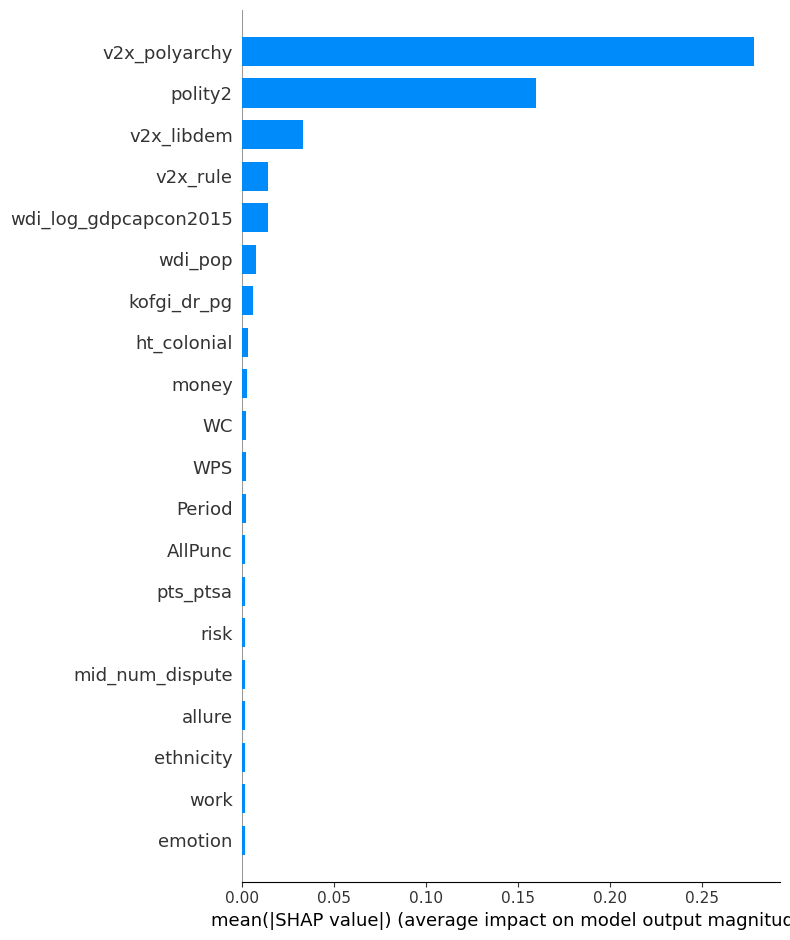

In [128]:
shap.summary_plot(shap_values, trainN.drop(columns=['dd_democracy']), plot_type='bar')

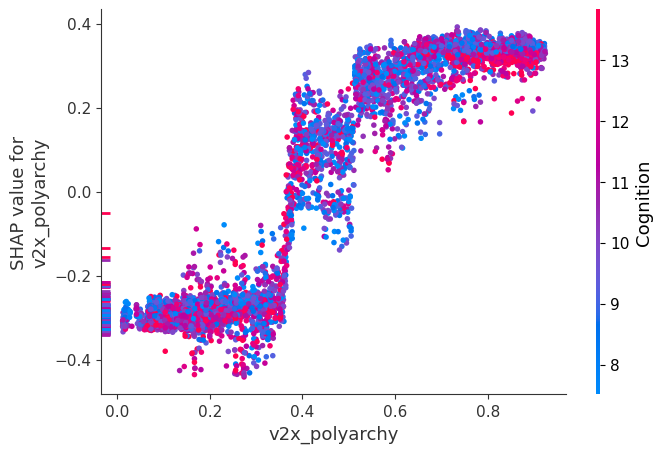

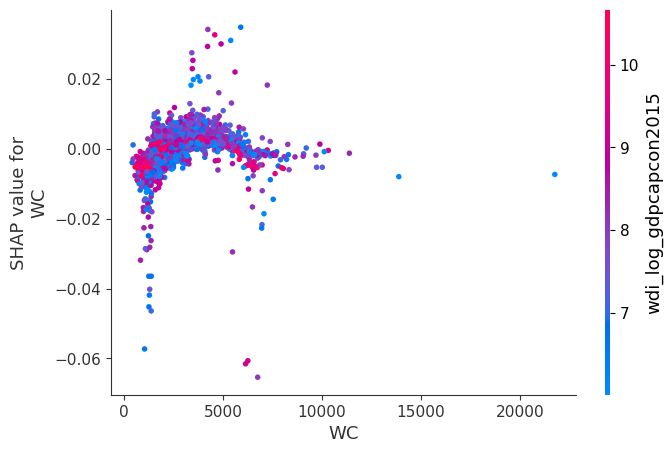

In [131]:
# This shows the impact of a single feature (WC in this case) across the dataset. 

shap.dependence_plot('v2x_polyarchy', shap_values, trainN.drop(columns=['dd_democracy']))

shap.dependence_plot('WC', shap_values, trainN.drop(columns=['dd_democracy']))


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


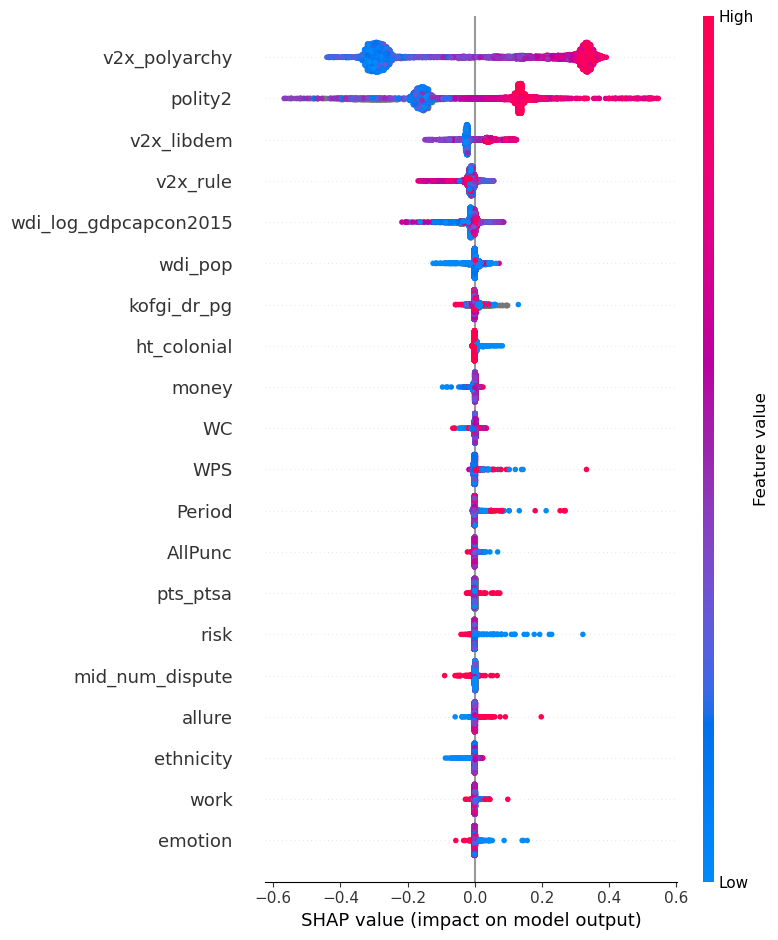

In [134]:
# Create summary plot
shap.summary_plot(shap_values, trainN.drop(columns=['dd_democracy']))


In [138]:
# Predictions and accuracy calculation
predictions = bag_democracy1.predict(testN.drop(columns=['dd_democracy']))
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
confusion_mat = confusion_matrix(testN['dd_democracy'], predictions)

print("Confusion Matrix:")
print(confusion_mat)

TP = confusion_mat[1, 1]
TN = confusion_mat[0, 0]
FP = confusion_mat[0, 1]
FN = confusion_mat[1, 0]

# Accuracy
accuracy = (TP + TN) / np.sum(confusion_mat)

# Precision, Recall, F1-score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)



Confusion Matrix:
[[1381   84]
 [  68 1361]]
Accuracy: 0.9474775397373877
Precision: 0.9418685121107266
Recall: 0.9524142757172848
F1-score: 0.9471120389700766
